In [1]:
import os
import sys

src_path = r"C:\Users\asrit\Documents\516-Project\src"
if src_path not in sys.path:
    sys.path.append(src_path)

In [2]:
import pandas as pd
import numpy as np
import shap

from data_loader import load_dataset
from modeling import train_smote_forest, evaluate_model, train_random_forest
from fairness_metrics import print_group_rates, disparate_impact, equal_opportunity
from preprocess import apply_reweighing

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame, selection_rate
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds

from lime.lime_tabular import LimeTabularExplainer

pip install 'aif360[inFairness]'


In [3]:
# Load data
df = load_dataset("../data/cleaned_dataset.csv")

In [4]:
df_original = pd.read_csv("../data/cleaned_dataset.csv")

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_original['Gender'])

for i, label in enumerate(le.classes_):
    print(f"{i} → {label}")


0 → Man
1 → NonBinary
2 → Woman


# Pre-Processing

Using a preprocessing mitigation strategy - AIF360’s Reweighing

In [5]:
# Step 1: Apply AIF360 Reweighing (only used for fairness metrics, not for training if SMOTE is applied)
df = apply_reweighing(df, protected_attr='Gender', label_col='Employment')

# Step 2: Feature engineering for modeling
features = ['Gender_encoded', 'Age_encoded', 'EdLevel', 'YearsCode', 'YearsCodePro', 'ComputerSkills', 'PreviousSalary']
X = pd.get_dummies(df[features], drop_first=True)
y = df['Employment'].astype(int)


In [6]:
# Step 3: Choose model strategy
use_smote = True  # Toggle this to False to use reweighing instead of SMOTE

if use_smote:
    model, X_test, y_test, y_pred = train_smote_forest(X, y)
else:
    sample_weights = df['instance_weight']
    model, X_test, y_test, y_pred = train_random_forest(X, y, sample_weights)

# Step 4: Evaluate base model performance (before fairness post-processing)
evaluate_model(y_test, y_pred)


Accuracy: 0.7463133536004356
Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.25      0.19      2571
           1       0.89      0.81      0.85     19468

    accuracy                           0.75     22039
   macro avg       0.52      0.53      0.52     22039
weighted avg       0.81      0.75      0.77     22039



In [7]:
# Step 5: Custom fairness metrics based on fairness-aware predictions
print_group_rates(df, 'Gender')
print_group_rates(df, 'Age')
print_group_rates(df, 'EdLevel')

# Disparate impact comparisons
disparate_impact(df, 2, 0, 'Gender')  # Woman vs Man
disparate_impact(df, 1, 0, 'Gender')  # NonBinary vs Man
disparate_impact(df, '>35', '<35', 'Age')

# Equal opportunity using fairness-aware predictions
equal_opportunity(
    y_test.reset_index(drop=True),
    pd.Series(y_pred), 
    [0, 1, 2],  # Man, NonBinary, Woman
    'Gender',
    df.reset_index(drop=True)
)



Selection Rates by Gender:
0: 0.88
2: 0.91
1: 0.87

Selection Rates by Age:
<35: 0.90
>35: 0.85

Selection Rates by EdLevel:
Master: 0.88
Undergraduate: 0.90
PhD: 0.90
Other: 0.84
NoHigherEd: 0.80

Disparate Impact (2/0): 1.03

Disparate Impact (1/0): 0.98

Disparate Impact (>35/<35): 0.95

Equal Opportunity by group:
0: TPR = 0.81
1: TPR = 0.82
2: TPR = 0.78


# In-processing

In [8]:
# Use already-SMOTEd X_test and y_test
# Retrieve sensitive features for test set
sensitive_feature_test = df.loc[X_test.index, "Gender_encoded"]
sensitive_feature_train = df.loc[X.index.difference(X_test.index), "Gender_encoded"]  # approximate train

# Remove sensitive attribute from features for fairness training
X_train_eg = X.loc[X.index.difference(X_test.index)].drop(columns=["Gender_encoded"])
y_train_eg = y.loc[X.index.difference(X_test.index)]

X_test_eg = X_test.drop(columns=["Gender_encoded"])

# Train in-processing model using exponentiated gradient
eg_model = ExponentiatedGradient(
    estimator=LogisticRegression(solver="liblinear", class_weight='balanced'),
    constraints=EqualizedOdds(),
    eps=0.01
)
eg_model.fit(X_train_eg, y_train_eg, sensitive_features=sensitive_feature_train)

# Predict and evaluate
y_pred_eg = eg_model.predict(X_test_eg)

# Evaluation
print("Exponentiated Gradient on SMOTE-balanced data:")
print("Accuracy:", accuracy_score(y_test, y_pred_eg))
print("Classification Report:")
print(classification_report(y_test, y_pred_eg))

# Fairness metrics by gender
mf_eg = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred_eg,
    sensitive_features=sensitive_feature_test
)
print("Fairness metrics by gender:")
print(mf_eg.by_group)

# Fairness metrics by Age
mf_eg_age = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred_eg,
    sensitive_features=df.loc[X_test.index, 'Age_encoded']
)
print("Fairness metrics by Age:")
print(mf_eg_age.by_group)

# Fairness metrics by EdLevel
mf_eg_edlevel = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred_eg,
    sensitive_features=df.loc[X_test.index, 'EdLevel']
)
print("Fairness metrics by EdLevel:")
print(mf_eg_edlevel.by_group)




Exponentiated Gradient on SMOTE-balanced data:
Accuracy: 0.6890512273696628
Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.29      0.18      2571
           1       0.89      0.74      0.81     19468

    accuracy                           0.69     22039
   macro avg       0.51      0.52      0.49     22039
weighted avg       0.80      0.69      0.73     22039

Fairness metrics by gender:
                accuracy  selection_rate
Gender_encoded                          
0               0.688310        0.737798
1               0.682464        0.739336
2               0.706628        0.745614
Fairness metrics by Age:
             accuracy  selection_rate
Age_encoded                          
0            0.703851        0.751062
1            0.661370        0.714118
Fairness metrics by EdLevel:
               accuracy  selection_rate
EdLevel                                
Master         0.694742        0.747318
NoHigherEd     

# Post Processing

In [9]:
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score, classification_report

# Ensure you're using reweighed training data (pre-processing)
use_smote = False  # Ensure no SMOTE is applied

if not use_smote:
    sample_weights = df['instance_weight']
    model, X_test, y_test, y_pred = train_random_forest(X, y, sample_weights)

# Apply post-processing: ThresholdOptimizer with Equalized Odds
postprocessor = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds",  # You can also test "demographic_parity"
    predict_method="predict_proba"
)

# Fit fairness-aware thresholds based on sensitive group (gender)
postprocessor.fit(
    X_test, y_test,
    sensitive_features=df.loc[X_test.index, "Gender_encoded"]
)

# Predict using fairness-aware thresholds
y_pred_fair = postprocessor.predict(
    X_test,
    sensitive_features=df.loc[X_test.index, "Gender_encoded"]
)

# ---------------------
# Evaluation: Performance & Fairness
# ---------------------

# Fairness-aware predictions: Gender
print("Fairness-aware Evaluation (No SMOTE) with Equalized Odds:")

mf_post_gender = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=df.loc[X_test.index, "Gender_encoded"]
)
print("Fairness metrics by Gender:")
print(mf_post_gender.by_group)

# Fairness-aware predictions: Age
mf_post_age = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=df.loc[X_test.index, "Age_encoded"]
)
print("\nFairness metrics by Age:")
print(mf_post_age.by_group)

# Fairness-aware predictions: EdLevel
mf_post_edlevel = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=df.loc[X_test.index, "EdLevel"]
)
print("\nFairness metrics by EdLevel:")
print(mf_post_edlevel.by_group)

# ---------------------
# Overall Performance Evaluation
# ---------------------
print("\nOverall Accuracy:", accuracy_score(y_test, y_pred_fair))
print("Classification Report:")
print(classification_report(y_test, y_pred_fair))


Fairness-aware Evaluation (No SMOTE) with Equalized Odds:
Fairness metrics by Gender:
                accuracy  selection_rate
Gender_encoded                          
0               0.999903        0.882327
1               1.000000        0.872038
2               1.000000        0.906433

Fairness metrics by Age:
             accuracy  selection_rate
Age_encoded                          
0             0.99993        0.899937
1             0.99987        0.852045

Fairness metrics by EdLevel:
               accuracy  selection_rate
EdLevel                                
Master         0.999821        0.882153
NoHigherEd     1.000000        0.800000
Other          1.000000        0.841373
PhD            1.000000        0.895141
Undergraduate  0.999912        0.902964

Overall Accuracy: 0.9999092517809338
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2571
           1       1.00      1.00      1.00     194

# Explainability

## a) Proxy Mute

In [12]:
# Use KernelExplainer (since TreeExplainer or default may crash)
# Train-test split
X_train_pmute, X_test_pmute, y_train_pmute, y_test_pmute = train_test_split(X, y, test_size=0.3, random_state=42)

# Train base model (class-weighted Logistic Regression)
lr_model_base = LogisticRegression(solver="liblinear", class_weight='balanced')
lr_model_base.fit(X_train_pmute, y_train_pmute)

explainer = shap.KernelExplainer(
    lr_model_base.predict_proba,
    X_train_pmute.sample(100, random_state=42)  # Subsample for speed
)

# Explain top 100 test samples
shap_values = explainer.shap_values(X_test_pmute[:100])

# Compute mean absolute SHAP importance for class 1 ("Employed")
mean_abs_shap = np.abs(shap_values[1]).mean(axis=0)

# Build summary DataFrame
shap_summary = pd.DataFrame({
    "feature": X_train_pmute.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values(by="mean_abs_shap", ascending=False)

# Show top proxy candidates to re-select or revise
shap_summary.head(10)


  0%|          | 0/100 [00:00<?, ?it/s]

,feature,mean_abs_shap
3,YearsCodePro,0.070045
5,PreviousSalary,0.055022
9,EdLevel_Undergraduate,0.039066
4,ComputerSkills,0.023982
2,YearsCode,0.014294
1,Age_encoded,0.008298
7,EdLevel_Other,0.007283
6,EdLevel_NoHigherEd,0.003020
0,Gender_encoded,0.002092
8,EdLevel_PhD,0.000783


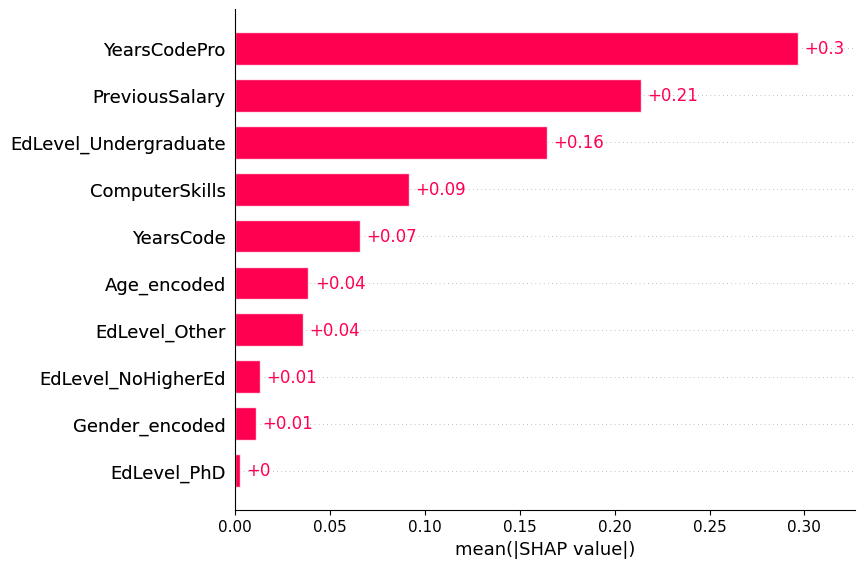

In [17]:

# SHAP explainability
explainer = shap.Explainer(lr_model_base, X_train_pmute)
shap_values = explainer(X_test_pmute)

# Plot feature importance
shap.plots.bar(shap_values, max_display=10)

# Define proxy features (based on the above cell output)
proxy_features= [
    'PreviousSalary',
    'EdLevel_Undergraduate',
    'ComputerSkills'
]



In [18]:
# Mute proxy features by replacing them with mean
X_test_muted = X_test_pmute.copy()
for col in proxy_features:
    if col in X_test_muted.columns:
        X_test_muted[col] = X_test_muted[col].mean()

# Predict and evaluate
y_pred_muted = lr_model_base.predict(X_test_muted)

print("ProxyMute (Revised Proxy List):")
print("Accuracy:", accuracy_score(y_test_pmute, y_pred_muted))
print("Classification Report:")
print(classification_report(y_test_pmute, y_pred_muted))

# Gender fairness on muted predictions
mf_shap_gender = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test_pmute,
    y_pred=y_pred_muted,
    sensitive_features=df.loc[X_test_pmute.index, "Gender_encoded"]
)
print("Fairness metrics by Gender (ProxyMute SHAP):")
print(mf_shap_gender.by_group)

# Firness metrics by Age
mf_shap_age = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test_pmute,
    y_pred=y_pred_muted,
    sensitive_features=df.loc[X_test_pmute.index, "Age_encoded"]
)
print("Fairness metrics by Age (ProxyMute SHAP):")
print(mf_shap_age.by_group)

#Fairness metrics by Edlevel
mf_shap_edlevel = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test_pmute,
    y_pred=y_pred_muted,
    sensitive_features=df.loc[X_test_pmute.index, "EdLevel"]
)
print("Fairness metrics by EdLevel (ProxyMute SHAP):")
print(mf_shap_edlevel.by_group)


ProxyMute (Revised Proxy List):
Accuracy: 0.6709469576659558
Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.42      0.23      2571
           1       0.90      0.70      0.79     19468

    accuracy                           0.67     22039
   macro avg       0.53      0.56      0.51     22039
weighted avg       0.82      0.67      0.73     22039

Fairness metrics by Gender (ProxyMute SHAP):
                accuracy  selection_rate
Gender_encoded                          
0               0.663008        0.679374
1               0.720379        0.758294
2               0.809942        0.862573
Fairness metrics by Age (ProxyMute SHAP):
             accuracy  selection_rate
Age_encoded                          
0            0.859759        0.942622
1            0.317791        0.215811
Fairness metrics by EdLevel (ProxyMute SHAP):
               accuracy  selection_rate
EdLevel                                
Master         0.66

## b) Refined Proxy Mute

In [19]:
# Refined ProxyMute using LIME (Local Mute per Instance)
# Initialize LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train_pmute.values,
    feature_names=X_train_pmute.columns.tolist(),
    class_names=["Not Employed", "Employed"],
    mode="classification",
    discretize_continuous=False
)

# Apply local muting: top 2 features per instance
X_test_localmute_muted = X_test_pmute.copy()

for i in range(500):
    exp = explainer.explain_instance(
        X_test_pmute.iloc[i].values,
        lambda x: lr_model_base.predict_proba(pd.DataFrame(x, columns=X_train_pmute.columns)),
        num_features=2  # Only top 2 features
    )
    top_features = [f[0] for f in exp.as_list()]
    
    for f in top_features:
        f_name = f.split('<')[0].split('>')[0].split('=')[0].strip()
        if f_name in X_test_localmute_muted.columns:
            col_idx = X_test_localmute_muted.columns.get_loc(f_name)
            mean_val = X_train_pmute[f_name].mean()
            col_dtype = X_test_localmute_muted.dtypes[f_name]
            X_test_localmute_muted.iat[i, col_idx] = col_dtype.type(mean_val)

# Predict
y_pred_lime_localmute = lr_model_base.predict(X_test_localmute_muted)

# Evaluate performance
print("Refined ProxyMute (LIME, Top 2 Features):")
print("Accuracy:", accuracy_score(y_test_pmute, y_pred_lime_localmute))
print("Classification Report:")
print(classification_report(y_test_pmute, y_pred_lime_localmute))

# Evaluate fairness
for attr, label in [("Gender_encoded", "Gender"), ("Age_encoded", "Age"), ("EdLevel", "EdLevel")]:
    mf = MetricFrame(
        metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
        y_true=y_test_pmute,
        y_pred=y_pred_lime_localmute,
        sensitive_features=df.loc[X_test_pmute.index, attr]
    )
    print(f"\nFairness metrics by {label}:")
    print(mf.by_group)

Refined ProxyMute (LIME, Top 2 Features):
Accuracy: 0.6084214347293434
Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.56      0.25      2571
           1       0.91      0.62      0.74     19468

    accuracy                           0.61     22039
   macro avg       0.54      0.59      0.49     22039
weighted avg       0.83      0.61      0.68     22039


Fairness metrics by Gender:
                accuracy  selection_rate
Gender_encoded                          
0               0.599291        0.583896
1               0.682464        0.687204
2               0.761209        0.790448

Fairness metrics by Age:
             accuracy  selection_rate
Age_encoded                          
0            0.700021        0.719100
1            0.437093        0.364288

Fairness metrics by EdLevel:
               accuracy  selection_rate
EdLevel                                
Master         0.489807        0.452969
NoHigherEd     0.